In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import cv2, random
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [0]:

# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image
# import image

In [130]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [85]:
from google.colab import files

uploaded = files.upload() # this line will let you select path to upload file 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test_full_size.zip to test_full_size (1).zip
User uploaded file "test_full_size.zip" with length 38786180 bytes


In [1]:
# %cd 1
!ls
# check to see if the zip file get uploaded or not

datalab


In [0]:
# !unzip train.zip
# !unzip val.zip
# !unzip test.zip
!unzip "test_full_size (1).zip"

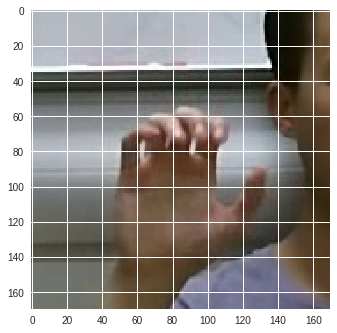

In [5]:
# test to show the image
plt.figure()
image = cv2.imread('train/1/137_1361_R.jpg')
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()



In [11]:
# check the type and shape of the image
print (type(image))
image.shape

# should be 170 x 170 x 3

<class 'numpy.ndarray'>


(170, 170, 3)

In [0]:
# load in the data
from torchvision.transforms import ToTensor


hand_train = dset.ImageFolder(root='train', transform=ToTensor())

loader_train = DataLoader(hand_train, shuffle=True)

hand_val = dset.ImageFolder(root='val',  transform=ToTensor())

loader_val = DataLoader(hand_val, shuffle=True)


In [12]:
# # print out classes in our data set, should print out  0 and 1, 0 for no hand and 1 for yes hand
print (hand_train.classes) 

print (hand_val.classes) 

['0', '1']
['0', '1']


In [9]:
noHand = 0
hand = 0
for i in range(len(hand_val)):
    x,y = hand_val[i]
    
    if y == 1:
      hand += 1
    else:
      noHand +=1
print("Number of data point of class hand: ",hand)
print("Number of data point of class no hand: ", noHand)

# print(type(hand_val[1]))

Number of data point of class hand:  5069
Number of data point of class no hand:  6363


In [10]:
noHand = 0
hand = 0
for i in range(len(hand_train)):
    x,y = hand_train[i]
    if y == 1:
      hand += 1
    else:
      noHand +=1
print("Number of data point of class hand: ",hand)
print("Number of data point of class no hand: ", noHand)


Number of data point of class hand:  6506
Number of data point of class no hand:  4028


In [0]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

def check_accuracy(model, loader):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        dummy = x.numpy()
        dummy = np.transpose(dummy)
        dummy = dummy[:,:,:,0]     
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
        
        if  ((preds == y).sum()) == 0:
          plt.figure()
          # openCV uses a different color scheme, change it back to RGB for plotting
#           RGB_img = cv2.cvtColor(dummy)
          plt.imshow(dummy)
          plt.show()

          print ("label: ",y)
          print ("Model predict: ", preds)
          
    acc = float(num_correct) / num_samples
    
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100 * acc
  
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
        
# define the flatten class
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [14]:
# control how often we print out the loss
print_every = 100

# select gpu data type
gpu_dtype = torch.cuda.FloatTensor

simple_model = nn.Sequential(
                # N x 3 x 170 x 170
                nn.Conv2d(3, 32, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(32), 
    
                nn.MaxPool2d(2, stride = 2), # N x 32 x 85 x 85
    
                # N x 32 x 85 x 85
                nn.Conv2d(32, 64, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(64), 
    
                nn.MaxPool2d(2, stride = 2), # N x 64 x 42 x 42
    
                nn.Dropout2d(p=0.2),

                # N x 64 x 42 x 42
                nn.Conv2d(64, 128, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(128), 
    
                nn.MaxPool2d(2, stride = 2), # N x 128 x 21 x 21
    
                # N x 128 x 21 x 21
                nn.Conv2d(128, 256, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(256), 
    
                nn.MaxPool2d(2, stride = 2), # N x 256 x 10 x 10
    
                Flatten(), # N x 4096
                nn.Linear(25600, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 2),
                nn.ReLU(inplace=True),
                nn.Softmax(dim=1),
              ) 




# test model
# simple_model = nn.Sequential(
#                 # N x 3 x 170 x 170
#                 nn.Conv2d(3, 32, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(32), 
    
#                 nn.MaxPool2d(2, stride = 2), # N x 32 x 85 x 85
    
#                 # N x 32 x 85 x 85
#                 nn.Conv2d(32, 64, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(64), 
    
#                 nn.MaxPool2d(2, stride = 2), # N x 64 x 42 x 42
    
#                 nn.Dropout2d(p=0.2),

#                 # N x 64 x 42 x 42
#                 nn.Conv2d(64, 128, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(128), 
    
#                 nn.MaxPool2d(2, stride = 2), # N x 128 x 21 x 21
    
#                 # N x 128 x 21 x 21
#                 nn.Conv2d(128, 256, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(256), 
    
#                 nn.MaxPool2d(2, stride = 2), # N x 256 x 10 x 10
    
    
#                 # N x 256 x 10 x 10
#                 nn.Conv2d(256, 512, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(512),
    
    
#                 nn.MaxPool2d(2, stride = 2), # N x 512 x 5 x 5
    
    
#                  # N x 512 x 5 x 5
#                 nn.Conv2d(512, 1024, kernel_size=3, stride=1,padding =1),
#                 nn.BatchNorm2d(1024),
    
    
#                 nn.MaxPool2d(2, stride = 2), # N x 1024 x 2 x 2
    
#                 Flatten(), # N x 4096
#                 nn.Linear(4096, 2048),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(2048, 1024),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(1024, 512),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(512, 2),
#                 nn.Softmax(dim=1),
#               ) 


#print ("Success")

Success


In [0]:
# Training process:

# transform the model into gpu capable
model_gpu = copy.deepcopy(simple_model).type(gpu_dtype)

# declare loss function and optimizer
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)

# declare optimizer
optimizer = optim.Adam(model_gpu.parameters(), lr=1e-7) # can change the learning rate here 

train(model_gpu, loss_fn, optimizer, num_epochs=1)

acc = check_accuracy(model_gpu, loader_val)

print (acc)

In [0]:
# Checking accuracy
acc = check_accuracy(model_gpu, loader_val)


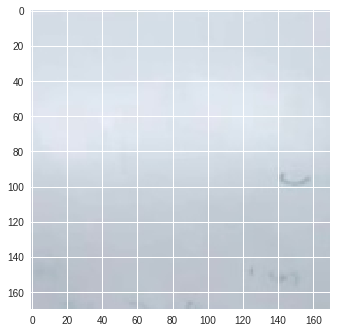

Variable containing:
 2.4665e-16  1.0000e+00
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

Model predict:  
 1
[torch.LongTensor of size 1]



In [23]:
# Manual testing!
# read in an image and print out which class it predict (1 for patch with hands, 0 otherwise)

image2 = cv2.imread('test/026_2063026_2063_17_27.jpg')

# show the image
plt.figure()
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

model_gpu.eval()
a2 = image2
test2 = torch.from_numpy(a2)  # convert the numpy array into torch tensor
test2 = test2.unsqueeze(0) # add another dimension to the torch
test2 = test2.permute(0, 3, 1, 2) # rearrange the axis to match the model
x_var2 = Variable(test2.type(gpu_dtype)) # convert into a variable to feed into the model
scores2 = model_gpu(x_var2) # get the score for this prediction

# see what its getting for the score
print (scores2)

_, preds = scores2.data.cpu().max(1) # get the predictions (should be either class 0 or class 1)
print ("Model predict: ", preds)

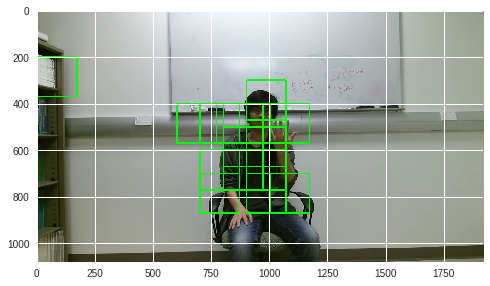

18


In [134]:
# demo part here!!

# Please define the name of the image you want to detect hand here
# If the file is located inside another folder, Please specify the 
# path to the file as well, 
# ex: if the file is name a.jpg and is within folder file, please
#     specify the name_of_file = 'file/a.jpg'
name_of_file = 'test_full_size/009_257.jpg'


# look for the name of the file
toPredict = cv2.imread(name_of_file)

# show the image
plt.figure()
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(toPredict, cv2.COLOR_BGR2RGB)

# Using the sliding window approach to predict the location of hands
# sliding window with same stride of 170 (same as creating a grid!)
dimension = toPredict.shape
endCol = dimension[1]-170 # the last column
endRow = dimension[0]-170 # the last row


listOfHand = [];



for row in range(0,endRow-170,100):
  for col in range(0,endCol-170,100):
    crop_img = toPredict[ row :row+170  , col : col+170] # crop a window of 170x170 pixels
    # do prediction for this image using the model!
    model_gpu.eval()
    crop_img_torch = torch.from_numpy(crop_img)  # convert the numpy array into torch tensor
    crop_img_torch = crop_img_torch.unsqueeze(0) # add another dimension to the torch
    crop_img_torch = crop_img_torch.permute(0, 3, 1, 2) # rearrange the axis to match the model
    x_var = Variable(crop_img_torch.type(gpu_dtype)) # convert into a variable to feed into the model
    scores = model_gpu(x_var) # get the score for this prediction
    _, preds = scores.data.cpu().max(1) # get the predictions (should be either class 0 or class 1)
    preds = preds.numpy()
    # drawing the bounding box!!
    # get the prediction for this small patch
#     a = scores.to(torch.device("cpu"))
#     scores_numpy = (scores.to(torch.device("cpu"))).numpy()
    if (preds == 1): # if the prediction is 1, draw a rectangle around the region
      cv2.rectangle(RGB_img, (col, row), (col+170, row+170), (0,255,0),  thickness=5)
      
plt.imshow(RGB_img)
plt.show()
print(count)

In [0]:
# As you can see, this model doesn't perform very well compared to our project.ipynb